# Building a Q&A chatbot application using RAG

*   Langsmith API: https://smith.langchain.com/o/19004a86-d6f8-4d4c-a840-bb9791a94564/settings/apikeys
*   Gemini API: https://aistudio.google.com/app/apikey



In [1]:
%pip install -qU langchain-text-splitters langchain-community langgraph

In [2]:
# Setup Langsmith API
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


# Components

Here, we are using Gemini models. For other models, refer to: https://python.langchain.com/docs/integrations/components/
*   **Chat Model:** Gemini
*   **Embeddings Model:** Gemini
*   **Vector Store:** In-Memory

In [3]:
# Install Gemini packages
%pip install -qU langchain-google-genai

In [4]:
# Setup Google API
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

Enter API key for Google Gemini: ··········


In [5]:
# Select a Chat Model (language models that use a sequence of messages as inputs and return messages as outputs)
from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [6]:
# Select Embeddings Model (create a vector representation of a piece of text)
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [7]:
# Select Vector Store (stores embedded data and performs similarity search)
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# Indexing

In [8]:
# Load contents of specified websites
import bs4
from langchain_community.document_loaders import WebBaseLoader

websites = ("https://www.telefonica.com/en/communication-room/blog/ai-classrooms-future-education/?_gl=1*9hz71t*_up*MQ..*_ga*MTUyOTI5OTQ4OS4xNzUwMjg2ODEy*_ga_HCS21JSWP8*czE3NTAyODY4MTIkbzEkZzAkdDE3NTAyODc3MzgkajYwJGwwJGgw",
            "https://www.telefonica.com/en/communication-room/blog/challenges-artificial-intelligence/")
bs4_strainer = bs4.SoupStrainer(["title", "header", "h1", "h2", "h3", "p"]) # only keep specific parts of the HTML

loader = WebBaseLoader(web_paths=websites, bs_kwargs={"parse_only": bs4_strainer})
docs = loader.load()

In [9]:
# Check loaded websites
assert len(docs) == len(websites)
print(f"Total characters: {len(docs[0].page_content)}") # length of 1st website
print(f"Total characters: {len(docs[1].page_content)}") # length of 2nd website

Total characters: 8122
Total characters: 8998


In [10]:
# Split document into smaller chunks to fit the context window
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Retrieval and Generation

Here, we use a pre-defined rag prompt template that can be found on [LangSmith hub](https://smith.langchain.com/hub/rlm/rag-prompt?_gl=1*o8bo4i*_gcl_au*ODY1MjU2MzguMTc0OTczNTQ1OQ..*_ga*MTE3NzIyNDQ2MC4xNzQ3MjQzODk1*_ga_47WX3HKKY2*czE3NTA0MzA2NTkkbzE2JGcxJHQxNzUwNDMxODc4JGo2MCRsMCRoMA..&organizationId=19004a86-d6f8-4d4c-a840-bb9791a94564):


> You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.  
>
> Question: {question}
>
> Context: {context}
>
> Answer:

In [11]:
# Define prompt for question-answering (Here, I use the pre-defined rag prompt template found here: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=19004a86-d6f8-4d4c-a840-bb9791a94564)
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [13]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# Define state for application (controls the data types during input, output, and everything in between)
class State(TypedDict):
    question: str
    context: List[Document]
    scores: List[float]
    answer: str

# Define application steps (retrieve and generate)
def retrieve(state: State):
  retrieved_docs_with_scores = vector_store.similarity_search_with_score(state["question"])
  docs = [doc for doc, score in retrieved_docs_with_scores]
  scores = [score for doc, score in retrieved_docs_with_scores]
  return {"context": docs, "scores": scores}

def generate(state: State):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = prompt.invoke({"question": state["question"], "context": docs_content})
  response = llm.invoke(messages)
  return {"answer": response.content}

In [14]:
# Use LangGraph to combine the retrieval and generation steps
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

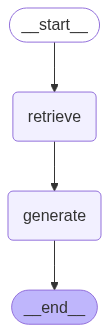

In [15]:
# Visualize control flow graph (CFG)
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Invoking

In [32]:
# Invoke
question_prompt = "Can you list each country listed in the articles along with their AI implementations and the associated risks?"

response = graph.invoke({"question": question_prompt})
print('Context:')
print(response["context"])
print('\nScores:')
print(response["scores"])
print('\nAnswer:')
print(response["answer"])

Context:
[Document(id='baad85bf-70a0-40ea-87b7-e96fdd7799bd', metadata={'source': 'https://www.telefonica.com/en/communication-room/blog/ai-classrooms-future-education/?_gl=1*9hz71t*_up*MQ..*_ga*MTUyOTI5OTQ4OS4xNzUwMjg2ODEy*_ga_HCS21JSWP8*czE3NTAyODY4MTIkbzEkZzAkdDE3NTAyODc3MzgkajYwJGwwJGgw', 'title': 'AI classrooms: The future of education - Telefónica'}, page_content='Nation’ strategy, Singapore is developing an AI system with the aim of increasing students’ academic performance. More specifically, this new system will offer a personalised experience through continuous assessment accompanied by feedback and corrections.Finally, despite not having a defined implementation strategy as in the previous two cases, Finland stands out for its unique approach to the application of AI in the classroom. Focusing on the well-being of students, the country is designing an AI system that not only allows for personalisation of teaching, but also collects data on emotional and psychological state w